In [1]:
import sys, joblib
sys.path.append('../../..')
from grid import *
import scipy.special
import matplotlib.pyplot as plt
import analyze_tools
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DATA = analyze_tools.data
DATA.pen
DATA.explicit_mark

explicit_mark [51, 464, 481, 488]
pen [203, 367, 455, 479]


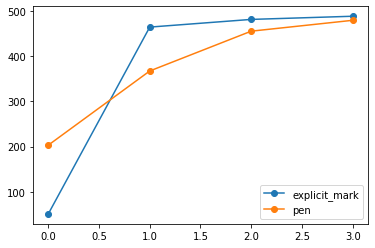

explicit_mark [52, 53, 53, 53]
pen [3, 6, 6, 6]


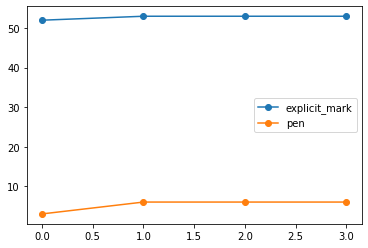

In [3]:
for name in ['explicit_mark', 'pen']:
    vs = [
        sum(
            1
            for task, tf in ii.iter_frontiers()
            if tf.is_solved()
        )
        for ii in getattr(DATA, name)
    ]
    print(name, vs)
    plt.plot(vs, '-o', label=name)
plt.legend()

plt.show()
plt.subplots()
for name in ['explicit_mark', 'pen']:
    vs = [
        (len(ii.result.grammars[-1].primitives) -
        len(ii.result.grammars[0].primitives))
        for ii in getattr(DATA, name)
    ]
    print(name, vs)
    plt.plot(vs, '-o', label=name)
plt.legend()

# Demo task rendering

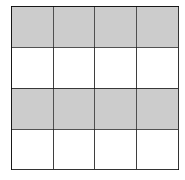

In [4]:
task, tf = next(DATA.explicit_mark[-1].iter_frontiers())
s = tf.execute_best(trace=True)['state']
analyze_tools.plot(tf)

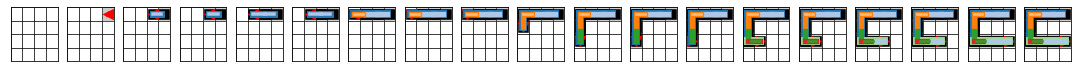

In [75]:
analyze_tools.plot_trace(tf.task.start, s.history)
analyze_tools.plot_trace(tf.task.start, s.history, animate=True)

(-0.5, 431.5, 287.5, -0.5)

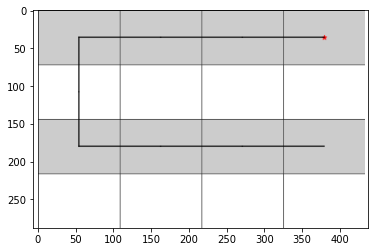

In [76]:
# showing buffer rendering
plt.figure()
plt.imshow(analyze_tools.plot_to_buffer(tf))
plt.axis('equal')

## Demo of simple case of stack trace rendering

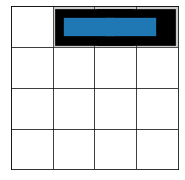

In [77]:
p =  Program.parse('''
(lambda (#(lambda (grid_move_no_mark (grid_mark_current_location $0))) (#(lambda (grid_move_no_mark (grid_mark_current_location $0))) $0)))
''')
s = analyze_tools.execute_grid(p, np.zeros((4, 4)), (3, 3), trace=True)
analyze_tools.plot(np.zeros((4, 4)), s.grid, s.history)

# showing all solutions

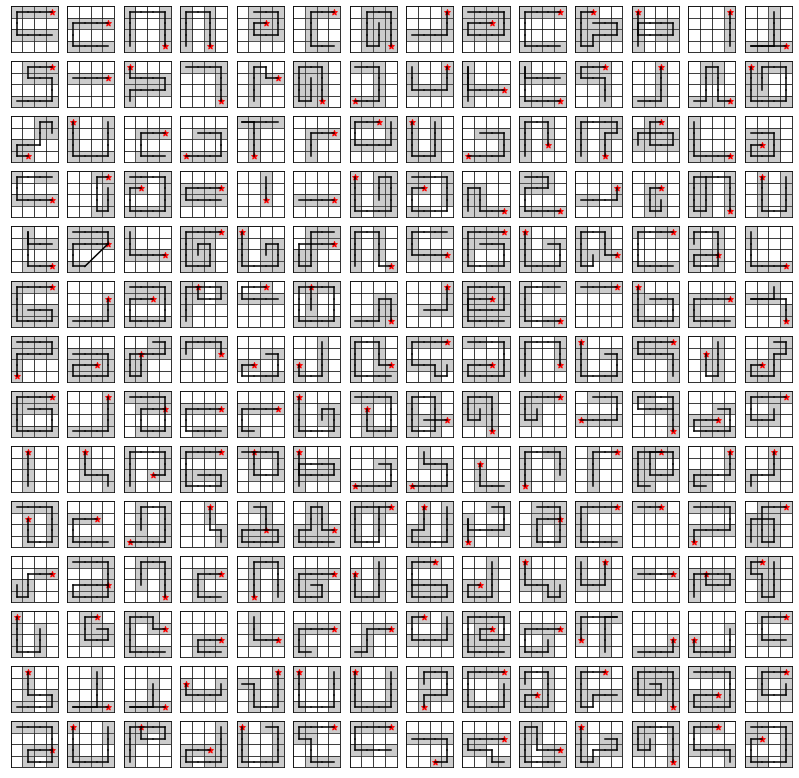

In [79]:
f, axes = plt.subplots(14, 14, figsize=(14, 14))
#f, axes = plt.subplots(7, 7, figsize=(10, 10))
axes = axes.flatten().tolist()
for ax in axes: ax.set(xticks=[], yticks=[])

for task, tf in DATA.explicit_mark[-1].iter_frontiers():
    if not tf.is_solved():
        continue
    analyze_tools.plot(tf, ax=axes.pop(0))
    if not axes:
        break

# visualize solutions over iterations


In [88]:
DATA.explicit_mark[1].result.taskSolutions[task]

Frontier(entries=[FrontierEntry(program=(lambda (#(lambda (grid_left (#(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0))))) (#(lambda (grid_move_no_mark (grid_left (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0)))))))) $0)))) $0)), logPrior=-5.858529019802839, logLikelihood=-12.0, FrontierEntry(program=(lambda (#(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0))))) (#(lambda (grid_right (#(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0))))) $0))) $0))), logPrior=-9.958532392343212, logLikelihood=-9.0], task=500_gsp_samples.npy_120)

In [83]:
def pairwise_iter(it):
    for prev, curr in zip(it[:-1], it[1:]):
        yield prev, curr

In [94]:
sum([
    sum([
        int(
            analyze_tools.TaskFrontier.from_result(prev.result, task).best_program_entry().program !=
            analyze_tools.TaskFrontier.from_result(curr.result, task).best_program_entry().program)
        for prev, curr in pairwise_iter(gram_iters)
    ])
    for task, tf in gram_iters[0].iter_frontiers()
])

756

In [189]:
gram_iters = DATA.explicit_mark[1:]

solved_iter0 = [
    task
    for task, tf in gram_iters[0].iter_frontiers()
    if tf.is_solved()
    if sum([
        int(
            analyze_tools.TaskFrontier.from_result(prev.result, task).best_program_entry().program !=
            analyze_tools.TaskFrontier.from_result(curr.result, task).best_program_entry().program)
        for prev, curr in pairwise_iter(gram_iters)
    ]) >= 2
]
print('total solved in iter0', len(solved_iter0))
random.shuffle(solved_iter0)
solved_iter0 = solved_iter0[:10]

xyz

for task in solved_iter0:
    s = 1.5
    f, axes = plt.subplots(1, len(gram_iters), figsize=(s * len(gram_iters), s))
    for t, ax in zip(gram_iters, axes):
        tf = analyze_tools.TaskFrontier.from_result(t.result, task)
        assert tf is not None, (task, tf)
        assert tf.is_solved(), (task, tf)
        analyze_tools.plot(tf, ax=ax, prog_to_coloridx=gram_iters[-1].default_prog_to_coloridx(), trace=True, style_plain=False)

    for t, ax in zip(gram_iters, axes):
        tf = analyze_tools.TaskFrontier.from_result(t.result, task)
        analyze_tools.plot_trace(tf)
    plt.show()

total solved in iter0 79


NameError: name 'xyz' is not defined

# rsa

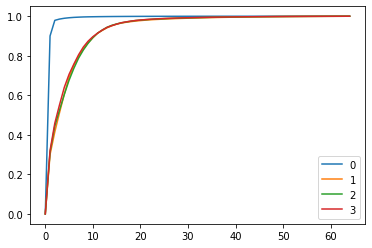

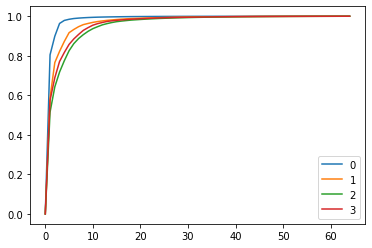

In [230]:
# Q: Why does iter0 of explicit mark look so blocky? It's b/c iteration0 is basically 1-dimensional.
for iters in [DATA.explicit_mark, DATA.pen]:
    plt.figure()
    for i in range(4):
        analyze_tools.TasksPlotter.svd(iters[i]).plot_explained_variance('-', cumulative=True, label=f'{i}')
    plt.legend()

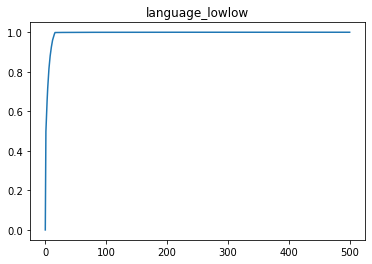

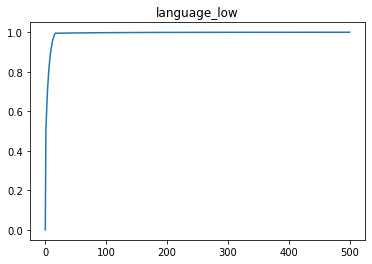

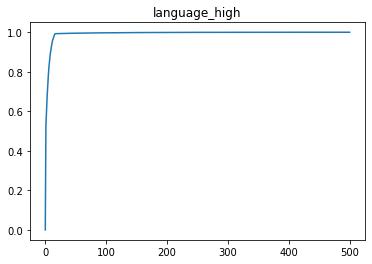

In [231]:
for name, mat in DATA.iter_lang():
    plt.figure()
    analyze_tools.TasksPlotter.svd(iters[0], data=mat).plot_explained_variance('-', cumulative=True)
    plt.title(name)


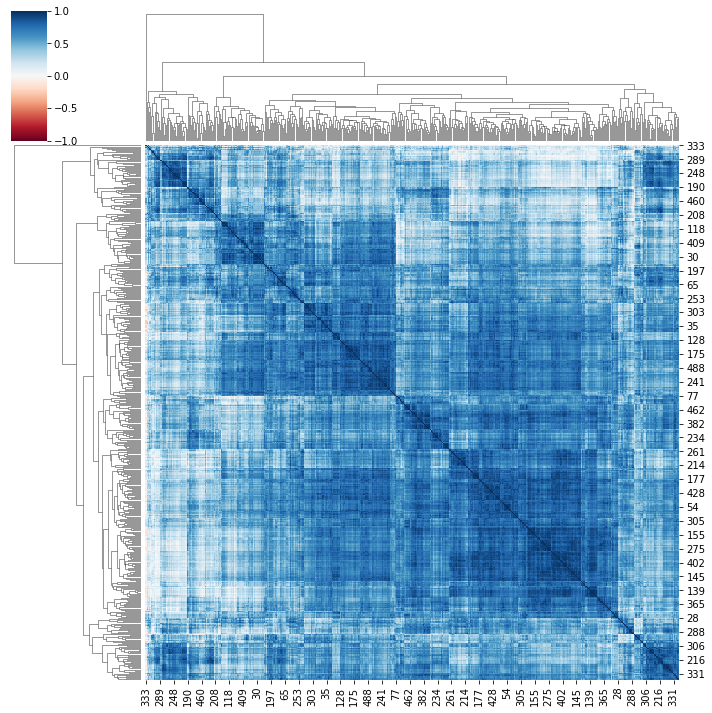

In [234]:
analyze_tools.TasksPlotter.plot_rdm(DATA.pen[3].recognition_embeddings())

In [201]:
for grammar in ['pen', 'explicit_mark']:
    g = getattr(DATA, grammar)
    for it in range(4):
        rdm(g[it].recognition_embeddings(), linkage_input=g[3].recognition_embeddings())
        analyze_tools.savefig(f'figures-rsa/correlation-{grammar}-it{it}.png')
    # now language
    for lang_name, lang in DATA.iter_lang():
        rdm(lang, linkage_input=g[3].recognition_embeddings())
        analyze_tools.savefig(f'figures-rsa/correlation-{grammar}-{lang_name}.png')

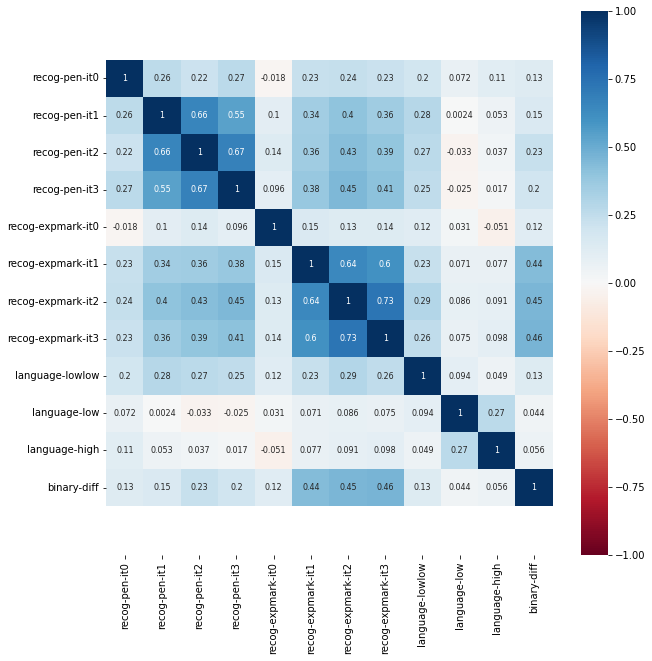

In [239]:
import pandas as pd

c = pd.DataFrame(nancorrcoef(np.array([
    nancorrcoef(arr)[np.triu_indices(len(DATA.pen[0].train))]
    for arr in (
        #[i.library_count_matrix() for i in DATA.pen] +
        [i.recognition_embeddings() for i in DATA.pen] +
        #[i.library_count_matrix() for i in DATA.explicit_mark] +
        [i.recognition_embeddings() for i in DATA.explicit_mark] +
        [
            DATA.language_lowlow,
            DATA.language_low,
            DATA.language_high,
            np.stack([t.goal.flatten() for t in pen_iters[0].train]),
        ]
    )
])))

c.index = c.columns = (
    #[f'libct-pen-it{i}' for i in range(4)] +
    [f'recog-pen-it{i}' for i in range(4)] +
    #[f'libct-expmark-it{i}' for i in range(4)] +
    [f'recog-expmark-it{i}' for i in range(4)] +
    [
        'language-lowlow',
        'language-low',
        'language-high',
        'binary-diff',
    ]
)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    c,
    cmap='RdBu', vmin=-1, vmax=+1,
    annot=True,
    annot_kws=dict(size=8),
)
plt.axis('equal')
analyze_tools.savefig('figures-rsa/rsa.png', close=False)

# language fine-tuned corr

In [244]:
def language_lowlow():
    x = np.load(f'data-language-embed/500_gsp_samples_text_lowlowlevel_encoded_finetuned.npy')
    return x.mean(axis=1)

def language_low():
    x = np.load(f'data-language-embed/500_gsp_samples_text_lowlevel_encoded_finetuned.npy', allow_pickle=True)
    return np.array([arr.mean(axis=0) for arr in x])

def language_high():
    x = np.load(f'data-language-embed/500_gsp_samples_text_highlevel_encoded_finetuned.npy', allow_pickle=True)
    return np.array([arr.mean(axis=0) for arr in x])

np.corrcoef(np.array([
    np.corrcoef(language_lowlow()).flatten(),
    np.corrcoef(language_low()).flatten(),
    np.corrcoef(language_high()).flatten(),
]))

array([[1.        , 0.99556188, 0.98455864],
       [0.99556188, 1.        , 0.98149484],
       [0.98455864, 0.98149484, 1.        ]])

# predicting gibbs choices

TODO
- make a light-weight alternative to exhaustive list of programs
- logistic regression choice model -> to get p-value. make "did finish" a factor, so we can eliminate the -1000 & fit it instead
- can neural network also predict between choices?

In [152]:
# this is 11gig in memory...
xx = joblib.load('/Users/carlos/Downloads/exhaustive-enum.bin')

{'frontier': Frontier(entries=[], task=exhaustive0),
 'totalProgramCount': 39936}

In [260]:
# How many could we solve?
sum(1
    for rr in tqdm(xx['results'])
    if any(e.logLikelihood > -500 for e in rr['frontier'].entries)) / len(xx['results'])

  0%|          | 0/65536 [00:00<?, ?it/s]

0.210723876953125

In [300]:
import pandas as pd
import json
df = pd.read_csv('/Users/carlos/Downloads/data_grulrep.csv')
df['definition'] = df.definition.apply(json.loads)
df['vector'] = df.definition.apply(lambda d: np.array(d['vector']))

In [301]:
import scipy.special
def xxxx(df, exhaustive_enum):
    def vector_to_task_index(v):
        # HACK: a lot of assumptions here! in particular, whether it's row vs col order?
        tot = 0
        for i, val in enumerate(v[::-1]):
            tot += val << i
        return tot

    rv = []
    expected_ct = 0
    for network_id, rows in df.groupby('network_id'):
        expected_ct += rows.shape[0] - 1 # we skip last person in chain
        rows = list(rows.itertuples())
        for curr, next_ in zip(rows[:-1], rows[1:]):
            idx = curr.definition['active_index']
            comparison = curr.vector == next_.vector
            assert comparison[:idx].all() and comparison[idx+1:].all()
            assert (exhaustive_enum['tasks'][vector_to_task_index(curr.vector)].goal.flatten() == curr.vector).all(), 'sanity check'

            opt0 = np.copy(curr.vector)
            opt0[idx] = 0
            opt1 = np.copy(curr.vector)
            opt1[idx] = 1
            options = [
                opt0,
                opt1,
            ]
            options_task_index = [
                vector_to_task_index(opt0),
                vector_to_task_index(opt1),
            ]
            options_logpost = [
                max(
                    exhaustive_enum['results'][ti]['frontier'].entries,
                    key=lambda e: e.logPosterior,
                ).logPosterior
                for ti in options_task_index
            ]
            options_p = scipy.special.softmax(options_logpost)
            # this is a bit of a hack: it corresponds both to the choice b/w 0 and 1
            # and also is an index into the `options` array.
            selected_task_index = vector_to_task_index(next_.vector)
            assert selected_task_index in options_task_index
            selected_binary = next_.vector[idx]
            selected_p = options_p[selected_binary]
            rv.append(dict(
                options=options,
                options_task_index=options_task_index,
                options_logpost=options_logpost,
                selected_task_index=selected_task_index,
                selected_binary=selected_binary,
                selected_p=selected_p,
            ))
    assert len(rv) == expected_ct

    return pd.DataFrame(rv)

summary = xxxx(df, xx)
print(
    summary.selected_p.mean(),
    summary.selected_p.std() / np.sqrt(len(summary)),
)

0.6175864218960032 0.0028005111513690535


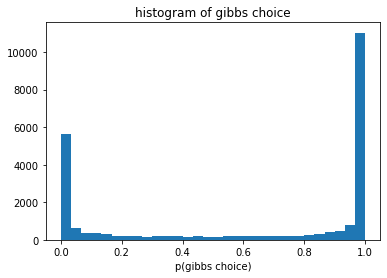

In [305]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(summary.selected_p.values, bins=30)
plt.title('histogram of gibbs choice')
plt.xlabel('p(gibbs choice)')
None

# dreams

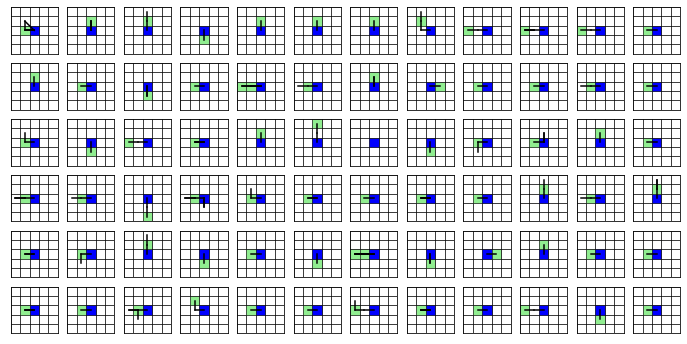

In [111]:
def dream_grammar(g):
    f, axes = plt.subplots(6, 12, figsize=(12, 6))
    axes = axes.flatten().tolist()

    #trivial = dreamcoder.program.Abstraction(dreamcoder.program.Index(0))
    programs = []

    for ax in axes:
        start, location = np.array([[0]*5]*5), (2, 2)
        start[location] = 1
        for _ in range(20):
            p = g.sample(g.continuationType)
            '''
            if p != trivial:
                break
            '''
            s = executeGrid(p, GridState(start, location, history=[]))
            if s is None:
                continue
            if not np.all(start==s.grid):
                break
        showtask(start, s.grid, s.history, ax=ax)
        programs.append(p)

dream_grammar(result.grammars[0])

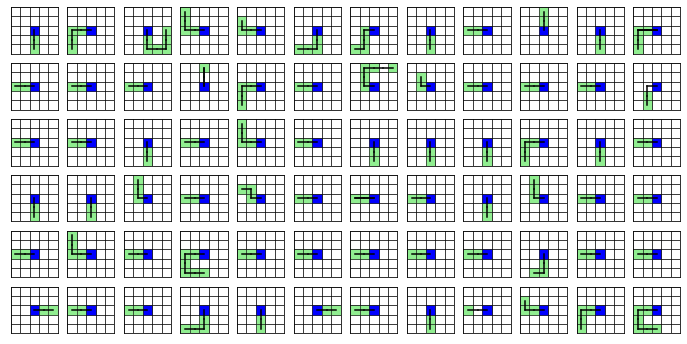

In [112]:
dream_grammar(result.grammars[1])

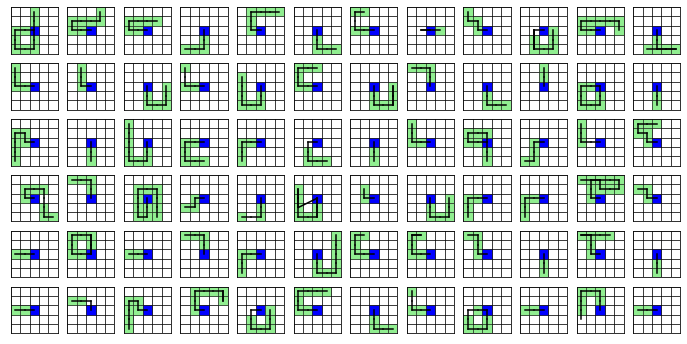

In [113]:
dream_grammar(result.grammars[2])

# library

In [18]:
def simplest_sorted_library(library):
    return sorted(
        library,
        # First we sort by # of references to other library items
        # then we sort by program length
        key=lambda fn: (len(str(fn).split('#')), len(str(fn))))

def distinct(idx, grammars):
    #prev = {p for g in grammars[:idx] for p in g.primitives}
    prev = {p for p in grammars[0].primitives}
    distinct = set(grammars[idx].primitives) - prev
    return simplest_sorted_library(distinct)

distinct(2, result.grammars)

[#(lambda (grid_move_no_mark (grid_mark_current_location $0))),
 #(lambda (grid_move_no_mark (grid_left (grid_mark_current_location $0)))),
 #(lambda (grid_move_no_mark (grid_right (grid_mark_current_location $0)))),
 #(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark $0)))),
 #(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0))))),
 #(lambda (grid_move_no_mark (grid_left (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0)))))))),
 #(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location (grid_right $0)))))))),
 #(lambda (grid_left (#(lambda (grid_move_no_mark (grid_mark_current_location $0))) $0))),
 #(lambda (#(lambda (grid_move_no_mark (grid_left (grid_mark_current_location $0)))) (grid_move_no_mark $0))),
 #(lambda (grid_right (#(lambda (gr

In [19]:
def simplify_signature(fn, tint_value):
    '''
    Plugs in a filler int value if the library routine takes them as parameters
    '''
    rewrote = False

    rv = fn
    ret = fn.infer()

    while ret.isArrow():
        arg, ret = ret.arguments

        if arg == tint:
            rewrote = True
            rv = Application(rv, primitives_numbers_only[tint_value-1])
            '''
        elif arg.isArrow(): # this is a complete hack & will only work for grid_cont -> grid_cont
            rewrote = True
            print('arrow arg', arg, 'rv', rv.infer(), rv)
            rv = Application(rv, Abstraction(Index(0)))
            print('rewrote to', rv.infer(), rv)
            '''
        else:
            rv = Application(rv, Index(0))

    if rewrote:
        return Abstraction(rv)
    else:
        return fn


KeyError: 'stack'

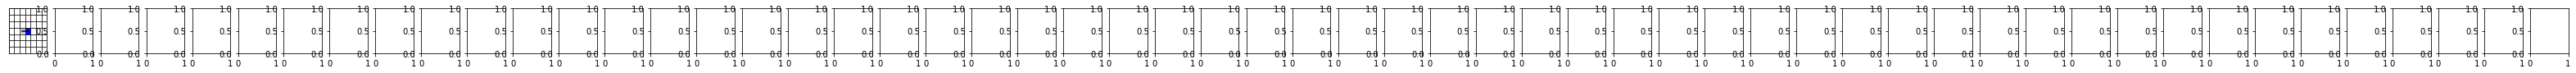

In [26]:
def exec_library_fn(fn):
    orig_fn = fn

    start, location = np.array([[0]*7]*7), (3, 3)
    fn = simplify_signature(fn, location[0])

    has_setloc = 'setloc' in str(fn) # HACK
    if has_setloc:
        # Need to do this to avoid cases where setloc is used incorrectly
        location = (-1, -1)
    else:
        start[location] = 1

    s = executeGrid(fn, GridState(start, location, history=[]))
    # HACK for some library functions, we haven't implemented a way to simplify above, so we
    # wind up with a callaback here.
    if callable(s):
        print('Could not execute library function with signature', orig_fn.infer())
        s = None
    return start, s

def visualize_functions(fns):
    if not fns:
        print('No functions')
        return

    f, axes = plt.subplots(1, len(fns), figsize=(len(fns), 1))

    for fn, ax in zip(fns, axes):
        start, s = exec_library_fn(fn)
        if s is None:
            continue
        analyze_tools.plot(start, s.grid, s.history, ax=ax)

visualize_functions(distinct(2, result.grammars))

In [ ]:
for i in range(1, len(result.grammars)):
    print(f'library after iteration {i}')
    visualize_functions(distinct(i, result.grammars))
    plt.show()

# visualizing traces of final library

In [21]:
items = distinct(2, result.grammars)
prog_desc_depth = simplest_sorted_library(items)
fnnames = {}
compressed = {}

def library_use_by_name(fn):
    strfn = str(fn)
    for subfn in prog_desc_depth[::-1]:
        if subfn in fnnames:
            strfn = strfn.replace(str(subfn), fnnames[subfn])
    return strfn

for i, fn in enumerate(prog_desc_depth):
    compressed[fn] = library_use_by_name(fn)
    fnnames[fn] = f'FN{i}'

In [22]:
def simple_use_of_library(p):
    '''
    Tries to identify cases where our program is just pretty directly using an abstraction.
    '''
    assert type(p) == Abstraction
    assert type(p.body) == Application
    f = p.body
    while type(f) != Invented and type(f) == Application:
        if type(f.x) not in (Primitive, Index):
            return False
        f = f.f
    return True

In [23]:
simple = []
for task in train[:50]:
    es = result.frontiersOverTime[task][-1].entries
    if not es:
        continue
    fe = max(es, key=lambda e: e.logPrior + e.logLikelihood) # get the best
    p = fe.program
    if simple_use_of_library(p):
        simple.append((task.name, library_use_by_name(p)))
        continue
    print(task, library_use_by_name(p))

print(f'{len(simple)} simple programs: {" ".join(map(str, simple))}')

500_gsp_samples.npy_0 (lambda (FN52 (FN4 $0)))
500_gsp_samples.npy_1 (lambda (FN52 (FN4 $0)))
500_gsp_samples.npy_2 (lambda (FN9 (FN54 $0)))
500_gsp_samples.npy_3 (lambda (FN9 (FN54 $0)))
500_gsp_samples.npy_4 (lambda (FN30 (FN27 $0)))
500_gsp_samples.npy_5 (lambda (FN4 (FN22 $0)))
500_gsp_samples.npy_6 (lambda (FN9 (FN28 (FN30 $0))))
500_gsp_samples.npy_8 (lambda (FN20 (FN7 (FN30 $0))))
500_gsp_samples.npy_9 (lambda (FN4 (FN54 $0)))
500_gsp_samples.npy_10 (lambda (FN15 (FN30 (FN15 $0))))
500_gsp_samples.npy_11 (lambda (FN7 (FN1 (FN42 (FN10 $0)))))
500_gsp_samples.npy_13 (lambda (FN6 (FN50 $0)))
500_gsp_samples.npy_14 (lambda (FN15 (FN2 (FN55 $0))))
500_gsp_samples.npy_16 (lambda (FN18 (grid_right (FN38 (FN7 $0)))))
500_gsp_samples.npy_17 (lambda (FN9 (FN11 $0)))
500_gsp_samples.npy_18 (lambda (FN2 (grid_move_no_mark (FN18 $0))))
500_gsp_samples.npy_19 (lambda (FN9 (FN28 (FN30 $0))))
500_gsp_samples.npy_20 (lambda (grid_right (FN9 (FN22 $0))))
500_gsp_samples.npy_21 (lambda (FN33 (FN9 

In [24]:
for fn in prog_desc_depth:
    print(fnnames[fn], compressed[fn])
    start, s = exec_library_fn(fn)
    if s is None:
        continue
    show_trace(start, s)
    plt.show()

FN0 #(lambda (grid_move_no_mark (grid_mark_current_location $0)))


NameError: name 'show_trace' is not defined

# counting use of primitives

In [122]:
import collections
def count_primitives(p, *, ct=None):
    if ct is None:
        ct = collections.Counter()
    class Counter(object):
        def invented(self, e): e.body.visit(self)
        def primitive(self, e): ct[e]+=1
        def index(self, e): pass
        def application(self, e): e.f.visit(self); e.x.visit(self)
        def abstraction(self, e): e.body.visit(self)
    p.visit(Counter())
    return ct

def count_prim():
    for fn in [
        #'output/output-taskgrammar-iter4-grammarpen.bin',
        #'output/output-taskgrammar-iter4-grammarpen_setloc-recog.bin',
        'output.bin',
    ]:
        r = joblib.load(fn)
        ct = collections.Counter()
        topct = collections.Counter()
        for task in r['train']:
            es = r['result'].frontiersOverTime[task][-1].entries
            if not es:
                continue
            fe = max(es, key=lambda e: e.logPrior + e.logLikelihood) # get the best
            count_primitives(fe.program, ct=topct)
            for e in es:
                p = e.program
                count_primitives(p, ct=ct)
        print(fn)
        print('best program', topct)
        print('top5', ct)

count_prim()

output.bin
best program Counter({grid_move_no_mark: 3622, grid_mark_current_location: 3424, grid_right: 876, grid_left: 401})
top5 Counter({grid_move_no_mark: 17736, grid_mark_current_location: 16731, grid_right: 4323, grid_left: 1748})


# library dependencies
used to be (invention use context counting)

In [15]:
for c in sorted_prims:
    if c.isPrimitive:
        continue
    print(c)
    def execute_grid_tight_layout(program, *, program_start_shape=(7, 7), **kwargs):
        w, h = program_start_shape
        assert w == h
        mid = w//2

        # We first execute the program on an oversize grid -- we use the places
        # it marks to define how we set the start location to ensure tighter margins.
        start = np.zeros(program_start_shape)
        location = (mid, mid)
        s = analyze_tools.execute_grid(
            program,
            start,
            location,
            set_start_with_setlocation=False,
        )
        print(s, location)
    execute_grid_tight_layout(c)
    print()
    print()
    print()


#(lambda (grid_dopenup (grid_move (grid_dopendown (grid_move $0)))))
GridState([[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]], (1, 3), orientation=0, pendown=True, settings=Settings(cost_pen_change=False, cost_when_penup=False)) (3, 3)



#(lambda (grid_move (grid_right (grid_move (grid_right (grid_move $0))))))
GridState([[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]], (3, 4), orientation=2, pendown=True, settings=Settings(cost_pen_change=False, cost_when_penup=False)) (3, 3)



#(lambda (grid_move (grid_move (grid_right (grid_move (grid_move (grid_right (grid_move (grid_move $0)))))))))
GridState([[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0.

  0%|          | 0/11 [00:00<?, ?it/s]

#(lambda (grid_dopenup (grid_move (grid_dopendown (grid_move $0)))))
#(lambda (grid_move (grid_right (grid_move (grid_right (grid_move $0))))))
#(lambda (grid_move (grid_move (grid_right (grid_move (grid_move (grid_right (grid_move (grid_move $0)))))))))
#(lambda (grid_move (grid_move (grid_right (#(lambda (grid_dopenup (grid_move (grid_dopendown (grid_move $0))))) $0)))))
#(lambda (grid_move (grid_left (#(lambda (grid_dopenup (grid_move (grid_dopendown (grid_move $0))))) (grid_left (grid_move $0))))))


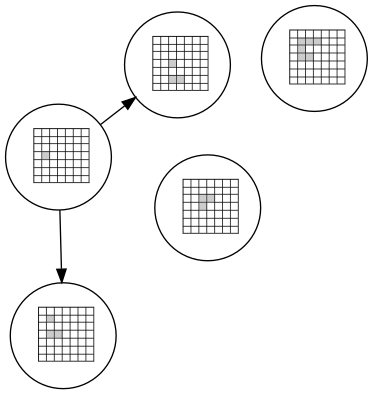

In [17]:
# code is a bit zany here -- i was previously trying to track down how frequently different libraries are being used
# if I rewrote just for library dependencies, I think I'd do analyze_tools.invention_counts without recursion to get the graph

#rr = DATA.explicit_mark[-1]
def load_dataset():
    sp = 1.5
    return DATA._load_sps('structurePenalty', lambda sp: f'3-sp{sp}-pen', primitives_pen, structurePenaltyValues=[sp])[sp]
rr = load_dataset()

v = analyze_tools.InventionUseContextCounting()
for task, tf in analyze_tools.iter_frontiers(rr.train, rr.result):
    if not tf.is_solved():
        continue
    tf.best_program_entry().program.visit(v)

sorted_prims = sorted(rr.result.grammars[-1].primitives, key=lambda p: (len(str(p)), str(p)))
inv_to_idx = {
    inv: i
    for i, inv in enumerate([p for p in sorted_prims if not p.isPrimitive])
}

import tempfile

import graphviz
g = graphviz.Digraph()
#g.attr(layout='dot', rankdir='LR')
g.attr(layout='fdp', K="1")

def _name(p):
    if p is None:
        return 'root'
    return str(inv_to_idx[p]) # has to be present!

in_root = set()
for (parent, child), ct in v.counts.items():
    if parent is None:
        in_root.add(child)
        continue
    assert inv_to_idx[parent] > inv_to_idx[child]
    p = _name(parent)
    c = _name(child)
    g.edge(c, p)

prog_to_coloridx = {}
with tempfile.TemporaryDirectory() as d:
    from tqdm.auto import tqdm
    #for c in tqdm(in_root):
    for c in tqdm(sorted_prims):
        if c.isPrimitive:
            continue
        print(c)
        im_path = os.path.join(d, f'{hash(str(c))}.png')
        f, ax = plt.subplots(1, 1, figsize=(1, 1))
        analyze_tools.plot(program=c, program_start_shape=(7, 7), ax=ax, prog_to_coloridx=prog_to_coloridx)
        plt.savefig(im_path, bbox_inches='tight')
        plt.close(f)
        g.node(
            _name(c),
            #label=_name(c)+f" ({v.counts[None, c]})",
            label=' ',
            image=im_path,
            size='.5',
        )
        #g.node('f', label='', image='/Users/carlos/pu/ec/dreamcoder/domains/grid/x.png')
    #g = g.unflatten(stagger=3) # didn't work...

    from IPython.display import display, Image
    display(Image(g._repr_image_png()))
    try:
        os.makedirs('figures-library')
    except:
        pass
    with open('figures-library/library.png', 'wb') as f:
        f.write(g._repr_image_png())

# indenting programs

In [306]:
import collections
def show_indented(p):
    class Indenter(object):
        def __init__(self):
            self.indent = 0
        def invented(self, e): return f'#{e.body.visit(self)}'
        def primitive(self, e): return f'{e.name}'
        def index(self, e): return f'${e.i}'
        def abstraction(self, e): return f'(lambda {e.body.visit(self)})'
        def application(self, e):
            self.indent += 1
            f = e.f.visit(self)
            x = e.x.visit(self)
            ipre = " " * (self.indent-1)
            i = " " * self.indent
            rv = f'''\n{ipre}(\n{i}{f}{x}\n{ipre})'''
            self.indent -= 1
            return rv
    return p.visit(Indenter())

print(show_indented(fe.program))

(lambda 
(
 #(lambda 
 (
  grid_move_no_mark
  (
   grid_mark_current_location
   (
    grid_move_no_mark
    (
     grid_mark_current_location$0
    )
   )
  )
 ))
 (
  #(lambda 
  (
   grid_move_no_mark
   (
    grid_mark_current_location
    (
     grid_right
     (
      #(lambda 
      (
       grid_move_no_mark
       (
        grid_mark_current_location$0
       )
      ))$0
     )
    )
   )
  ))
  (
   #(lambda 
   (
    grid_move_no_mark
    (
     grid_mark_current_location$0
    )
   ))$0
  )
 )
))


# dimensionality reduction
- anything to gather from plotEmbeddingWithImages?
- perplexity 30 & 50 both seemed good. Things largely seem invariant to random seed. Leaving out svd for now.

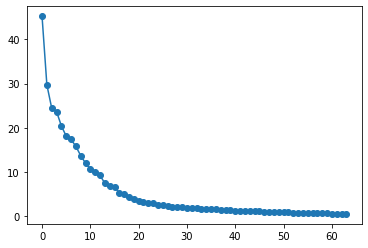

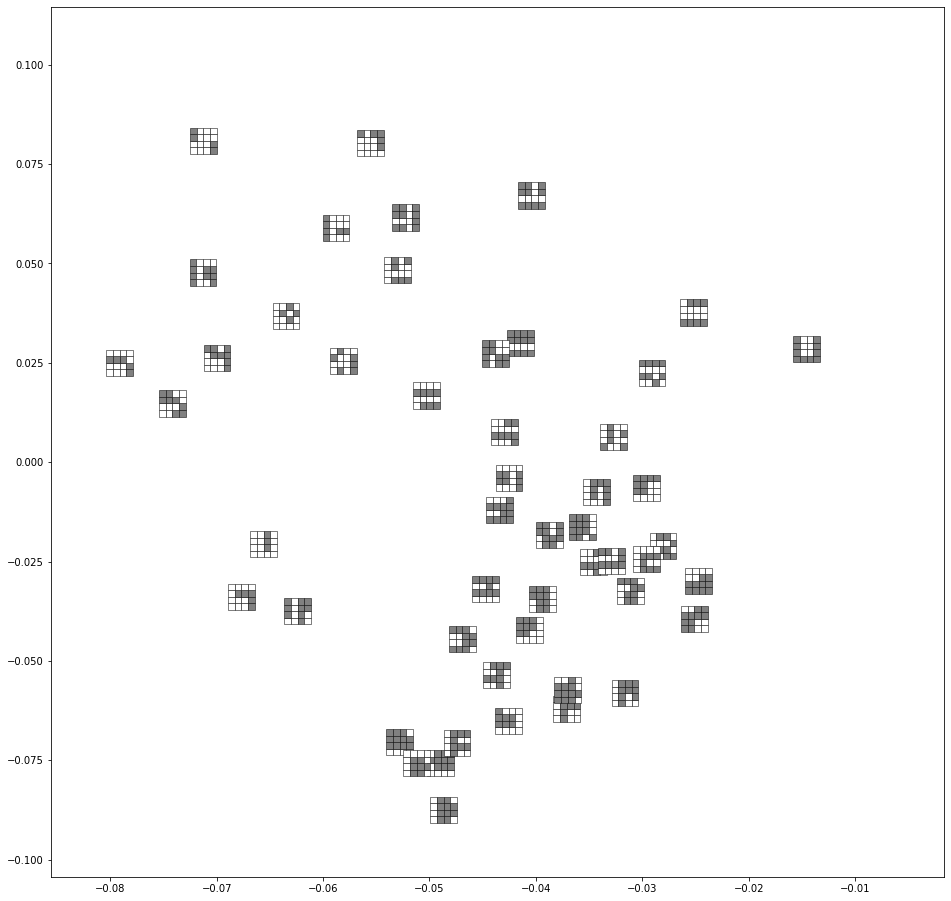

In [138]:
p = analyze_tools.TasksPlotter.svd(tasks)
p.plot_explained_variance()
p.plot()
#p.plot(show_trace=True)

In [27]:
def make_plots(key, p):
    base = f'figures-dimensionality-reduction/{key}'
    for s in [42]:
        p.plot(samples=100, seed=s, show_trace=False)
        analyze_tools.savefig(f'{base}-samp100s{s}.png')
    p.plot(samples=None, show_trace=False)
    analyze_tools.savefig(f'{base}-all.png')


'''
for grammar in ['pen', 'explicit_mark']:
    for it, tasks in enumerate(getattr(DATA, grammar)):
        make_plots(f'tsne-{grammar}-it{it}', analyze_tools.TasksPlotter.tsne(tasks, tsne_kwargs=dict(perplexity=30)))
'''
grammar = 'pen'
tasks = load_dataset()
assert tasks.arguments['structurePenalty'] == 1.5
make_plots(f'tsne-{grammar}-sp1.5', analyze_tools.TasksPlotter.tsne(tasks))

tasks = DATA.noConsolidation['pen']
make_plots(f'tsne-{grammar}-noConsolidation', analyze_tools.TasksPlotter.tsne(tasks))

In [29]:
tasks = DATA.pen[0] # HACK: the full 500
for name, lang in DATA.iter_lang():
    make_plots(f'tsne-{grammar}-lang{name}', analyze_tools.TasksPlotter.tsne(tasks, data=lang))